In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from sklearn.covariance import empirical_covariance
from tqdm import tqdm

np.random.seed(42)

In [2]:
ec_adata = sc.read_h5ad(filename='../data/preprocessed/ec_prepro.h5ad')
ec_adata

AnnData object with n_obs × n_vars = 5964 × 3379
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [3]:
est = empirical_covariance(ec_adata.X.A)

<Axes: >

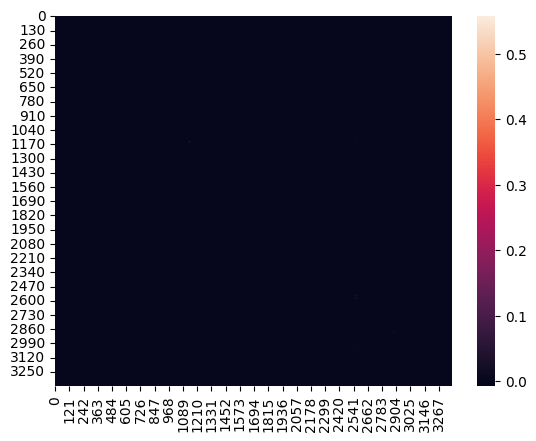

In [4]:
sns.heatmap(est)

In [5]:
sc.pp.highly_variable_genes(ec_adata, n_top_genes=50)
ec_adata_hvg50 = ec_adata[:, ec_adata.var['highly_variable']].copy()
ec_adata_hvg50

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 5964 × 50
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'hvg'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [6]:
est_hvg50 = empirical_covariance(ec_adata_hvg50.X.A)

<Axes: >

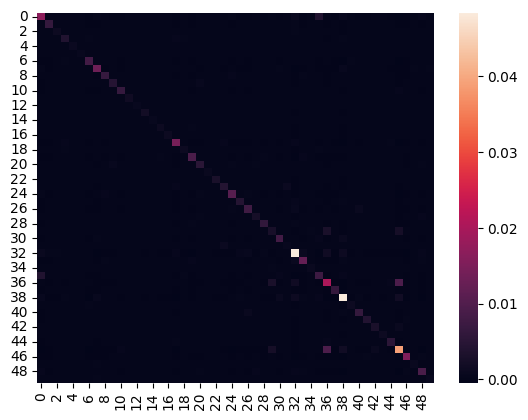

In [7]:
sns.heatmap(est_hvg50)

In [8]:
ec_adata_hvg50_bool_X = np.array(ec_adata_hvg50.X.A,dtype=bool)
print('Sparsity P: ', ec_adata_hvg50_bool_X.sum() / (ec_adata_hvg50_bool_X.shape[0] * ec_adata_hvg50_bool_X.shape[1]))

Sparsity P:  0.005744466800804829


In [10]:
ggl_est = gg_lasso_network_analysis(N=ec_adata_hvg50.shape[0], estimate=est_hvg50)
ggl_est.create_problem()
ggl_est.model_selection(lambda1_range=np.logspace(0, -5, 100))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 105 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 19 ite

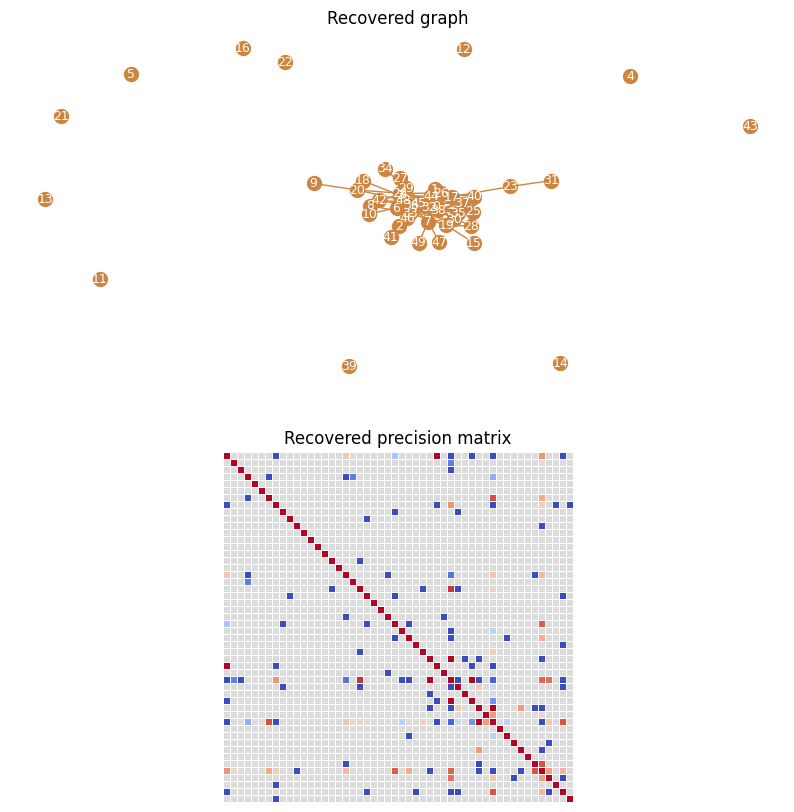

In [11]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))

In [14]:
print(ec_adata_hvg50.shape)
sc.pp.filter_cells(ec_adata_hvg50, min_genes=1)
print(ec_adata_hvg50.shape)

(5964, 50)
(1422, 50)


In [15]:
est_hvg50 = empirical_covariance(ec_adata_hvg50.X.A)

<Axes: >

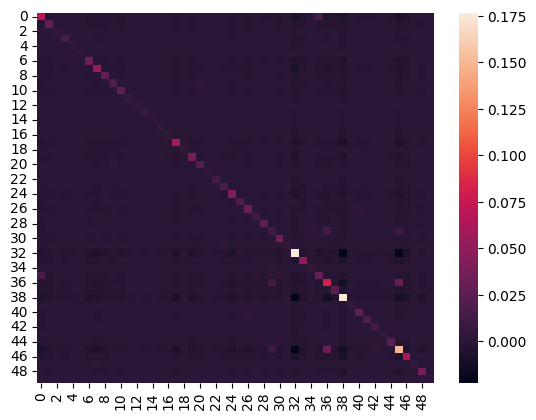

In [16]:
sns.heatmap(est_hvg50)

In [17]:
ec_adata_hvg50_bool_X = np.array(ec_adata_hvg50.X.A,dtype=bool)
print('Sparsity P: ', ec_adata_hvg50_bool_X.sum() / (ec_adata_hvg50_bool_X.shape[0] * ec_adata_hvg50_bool_X.shape[1]))

Sparsity P:  0.02409282700421941


In [18]:
ggl_est = gg_lasso_network_analysis(N=ec_adata_hvg50.shape[0], estimate=est_hvg50)
ggl_est.create_problem()
ggl_est.model_selection(lambda1_range=np.logspace(0, -5, 100))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 34 iterations with status: optimal.
ADMM terminated after 41 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 49 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 57 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 183 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 291 iterations with status: optimal.
ADMM terminated after 16 iterations 

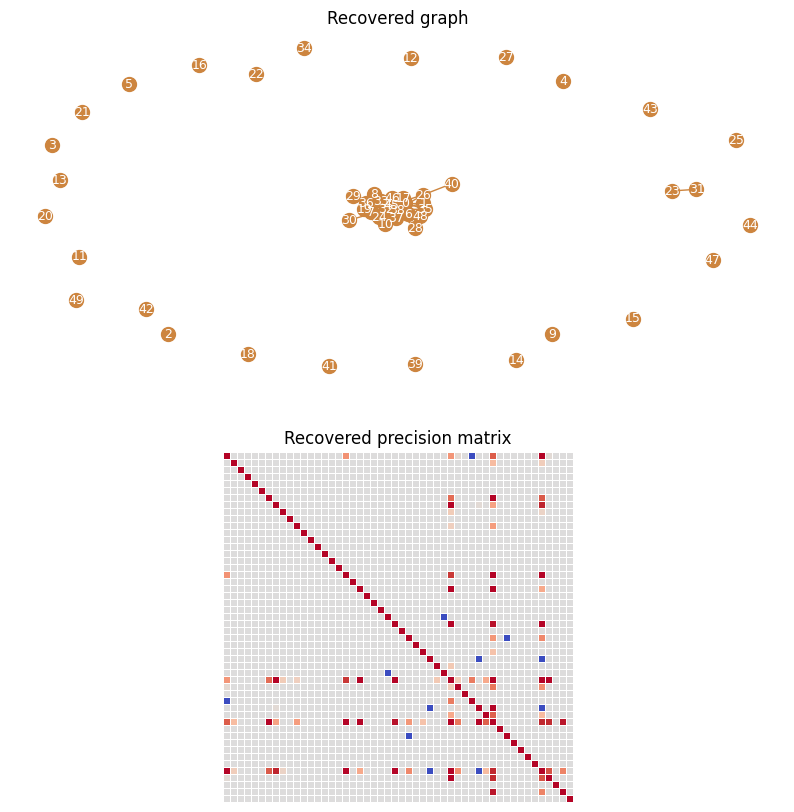

In [19]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))